In [186]:
portfolio_sd_t <- function(sd, cov, weight){
  stopifnot(length(sd) > 1, is.matrix(cov), length(sd) == length(weight))
  for(i in 1:(length(sd)-1)){
    for(j in (i+1):length(sd)){
      n <- sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2)
      m <- sum(2*weight[i]*weight[j]*cov[i,j])
      sd <- sqrt(sum(weight[i:length(sd)]^2*sd[i:length(sd)]^2+
                       2*weight[i]*weight[j]*cov[i,j]))
      return(sd)
    }
  }
}
portfolio_return <- function(returns, weight){
  if(!is.vector(returns) > 1){
    mean <- matrix(0, nrow = ncol(returns), ncol = 1)
    for(i in 1:ncol(returns)){
      mean[i] <- mean(as.matrix(returns[,i]), na.rm = T)
    }
  } else{
    if(is.vector(returns)){
      mean <- returns
    }
  }
  total_return <- sum(weight*mean)
  return(total_return)
}

In [187]:
options(warn = -1)
library(dplyr)
library(tidyr)
library(ggplot2)
library(tidyquant)
library(pracma)

In [188]:
#Estipule os parâmetros para calcular os desvios-padrão e os retornos médios (diários e anuais)
acoes <- c("BEEF3.SA","MGLU3.SA", "JHSF3.SA","TRPL4.SA","ITSA4.SA")
retornos_d <- tq_get(acoes, from = "2019-07-27", to = "2020-07-27") %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "daily")
retornos_a <- tq_get(acoes, from = "2014-07-27", to = "2020-07-27") %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun= periodReturn, period = "yearly") %>%
  mutate(year = year(date)) %>%
  group_by(year,symbol) %>%
  summarise(yearly.returns) %>%
  spread(key = "symbol", value = "yearly.returns")
sd_d <- retornos_d %>%
  group_by(symbol) %>%
  summarise(sd = sd(daily.returns)) %>%
  spread(key = "symbol", value = sd)
cov <- retornos_d %>%
  spread(key = "symbol", value = daily.returns)
cov$date <- NULL
cov <- cov(cov)

`summarise()` regrouping output by 'year' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [195]:
#Nº de simulações de carteiras a se fazer
n_sim <- 5000
pesos <- rand(length(acoes), n_sim)
for(i in 1:ncol(pesos)){
    pesos[,i] <- pesos[,i]/sum(pesos[,i])
}

In [196]:
riscos <- matrix(0,nrow = nrow(pesos), ncol = 1)
retornos <- matrix(0, nrow = nrow(pesos), ncol = 1)
for(i in 1:ncol(pesos)){
  riscos[i] <- portfolio_sd_t(sd = sd_d, cov = cov, weight = c(pesos[,i]))*sqrt(252)
  retornos[i] <- portfolio_return(retornos_a[,2:ncol(retornos_a)],
                                  weight = c(pesos[,i]))
}

In [197]:
#Sharpe
tx_livre_risco <- 0.0225
data <- data.frame(riscos = riscos, retornos = retornos, sharpe = (retornos-tx_livre_risco)/riscos)

In [198]:
#Retorno médio das ações
retorno_med <- retornos_a %>%
  gather(key = "symbol", value = "return", -year) %>%
  group_by(symbol) %>%
  summarise(media = mean(return)) %>%
  spread(key = "symbol", value = "media")

`summarise()` ungrouping output (override with `.groups` argument)



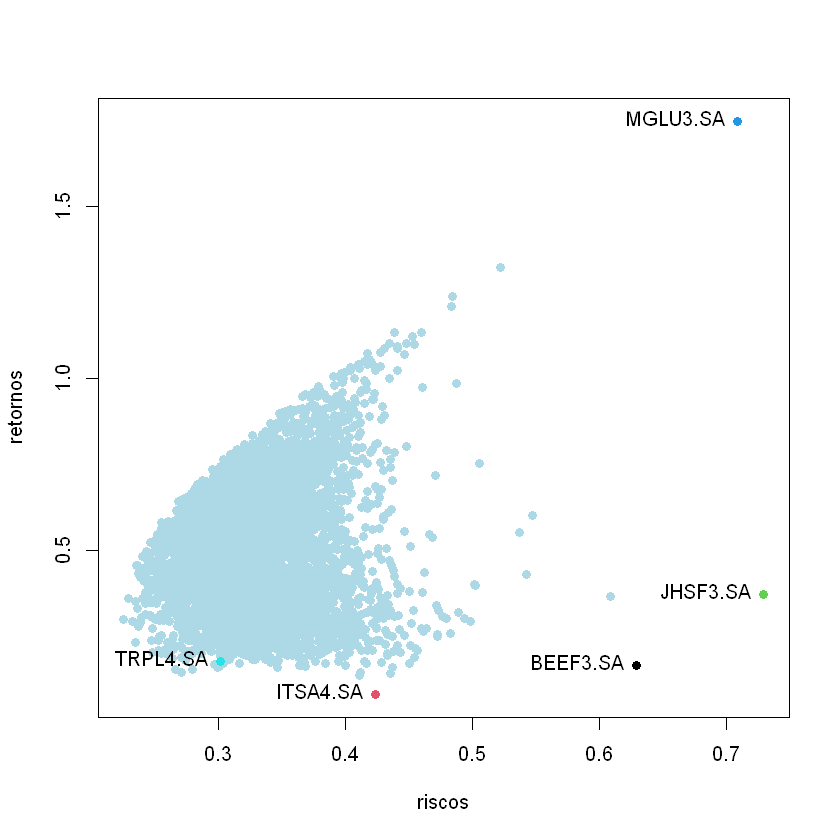

In [202]:
plot(riscos, retornos, pch = 16, col = "lightblue",xlim = c(min(riscos), max(sd_d*sqrt(252))),
    ylim = c(min(retorno_med), max(retorno_med)))
points(x = sd_d*sqrt(252), y = retorno_med, col = 1:ncol(retorno_med), pch = 16)
text(x = sd_d*sqrt(252), y = retorno_med, labels = colnames(retorno_med), pos = 2)

In [203]:
max(data$sharpe)

[1] 2.53366